**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import distance
import seaborn as sns
from sklearn.neighbors import KDTree
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups
from scipy import stats
from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfTransformer
%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [118]:
class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute', metric='minkowski'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm  
        self.metric = metric
    def fit(self, X, y):
        self.X = X
        self.y = y
        if self.algorithm == 'kd_tree':
            self.tree = KDTree(X, leaf_size=10)

    def predict(self, X):
        if self.algorithm == 'brute':
            idx = distance.cdist(X, self.X, self.metric).argsort(axis=1)[:, :self.n_neighbors]
        else:
            idx = self.tree.query(X, k=self.n_neighbors)[1]
        res = np.apply_along_axis(lambda ind: stats.mode(self.y[ind], axis=None)[0], -1, idx)
        return res.flatten()

    def predict_proba(self, X):
        if self.algorithm == 'brute':
            idx = distance.cdist(X, self.X, self.metric).argsort(axis=1)[:, :self.n_neighbors]
        else:
            idx = self.tree.query(X, k=self.n_neighbors)[1]
        prob = np.apply_along_axis(lambda ind: np.bincount(self.y[ind],
                                                           minlength = self.n_neighbors + 1), -1, idx)
        prob = prob.astype(float)
        prob /= self.n_neighbors
        return prob
         
    def score(self, X, y):
        res = self.predict(X)
        ans = (res == y)
        return ans.mean()

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [119]:
iris = datasets.load_iris()

In [120]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [121]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [122]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [123]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [124]:
%time clf.fit(X_train, y_train)

CPU times: user 495 µs, sys: 218 µs, total: 713 µs
Wall time: 497 µs


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [125]:
%time my_clf.fit(X_train, y_train)

CPU times: user 8 µs, sys: 0 ns, total: 8 µs
Wall time: 11.2 µs


In [126]:
%time clf.predict(X_test)

CPU times: user 2.04 ms, sys: 1.16 ms, total: 3.2 ms
Wall time: 2.1 ms


array([1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 2])

In [127]:
%time my_clf.predict(X_test)

CPU times: user 3.78 ms, sys: 943 µs, total: 4.73 ms
Wall time: 3.52 ms


array([1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 0, 1, 2, 2])

In [128]:
%time clf.predict_proba(X_test)

CPU times: user 1.04 ms, sys: 372 µs, total: 1.41 ms
Wall time: 1.08 ms


array([[0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ]])

In [129]:
%time my_clf.predict_proba(X_test)

CPU times: user 1.12 ms, sys: 448 µs, total: 1.57 ms
Wall time: 849 µs


array([[0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0.5, 0.5],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ]])

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [130]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [131]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [132]:
%time clf.fit(X_train, y_train)

CPU times: user 639 µs, sys: 365 µs, total: 1 ms
Wall time: 629 µs


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=2, p=2,
           weights='uniform')

In [133]:
%time my_clf.fit(X_train, y_train)

CPU times: user 159 µs, sys: 10 µs, total: 169 µs
Wall time: 165 µs


In [134]:
%time clf.predict(X_test)

CPU times: user 2.01 ms, sys: 1.24 ms, total: 3.26 ms
Wall time: 2.17 ms


array([2, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 1])

In [135]:
%time my_clf.predict(X_test)

CPU times: user 4.41 ms, sys: 1.32 ms, total: 5.73 ms
Wall time: 4.5 ms


array([2, 0, 0, 2, 0, 2, 1, 0, 2, 0, 1, 1, 1, 1, 1])

In [136]:
%time clf.predict_proba(X_test)

CPU times: user 885 µs, sys: 201 µs, total: 1.09 ms
Wall time: 944 µs


array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [137]:
%time my_clf.predict_proba(X_test)

CPU times: user 738 µs, sys: 416 µs, total: 1.15 ms
Wall time: 792 µs


array([[0., 0., 1.],
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [138]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [139]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])
type(newsgroups)

sklearn.utils.Bunch

In [140]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [141]:
import re

idx = []
target_new  = []
def func(text):
    text = re.sub(r'[a-z]([A-Z])', r'\1', text).lower()
    text = re.findall(r"[\w']+", text)
    return text

data_tok = []
for text in data:
    lis = func(text)
    if lis != []:
        data_tok.append(lis)
        target_new.append(target[data.index(text)])

target_new = np.array(target_new)

In [142]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [143]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [' '.join(i) for i in data_tok]
vectorizer = CountVectorizer(max_features=10000)
csr_matrix = vectorizer.fit_transform(corpus)


*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [112]:
from sklearn.model_selection import cross_val_score 

my_clf = MyKNeighborsClassifier(n_neighbors=2, metric='cosine')
csr_matrix_mod = TfidfTransformer().fit_transform(csr_matrix)
my_scores = cross_val_score(my_clf, csr_matrix_mod.todense(),  target_new, cv=3)
my_scores

[0.55658324 0.54498364 0.56885246]


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [144]:
# Так как MyKNeighborsClassifier работает все же медленней библиотеченого(особенно при 
# большом объеме данных), для того чтобы метод, 
# позволяющий найти оптимальное количество ближайших соседей, работал за адекватное время,
# я сделала его с использованием KNeighborsClassifier
full_vectorizer = CountVectorizer()
full_csr_matrix = full_vectorizer.fit_transform(corpus)
full_csr_matrix_mod = TfidfTransformer().fit_transform(full_csr_matrix)

In [145]:
def get_score(csr_mat, met):
    score = []
    for neighb in range(1, 11):
        clf = KNeighborsClassifier(n_neighbors=neighb, metric=met)
        score.append(cross_val_score(clf, csr_mat,  target_new, cv=3))
    return score 

In [146]:
sc1 = get_score(full_csr_matrix, 'minkowski')
sc2 = get_score(full_csr_matrix,'cosine')
sc3 = get_score(full_csr_matrix_mod, 'cosine')

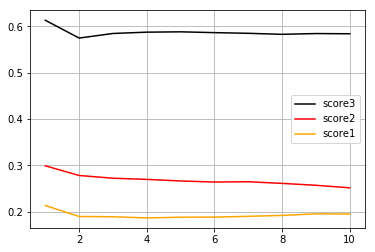

In [147]:
import matplotlib.pyplot as plt
x = np.arange(1, 11)
y = np.mean(sc3, axis = 1)
plt.plot(x, y, label = 'score3', color='black')
x = np.arange(1, 11)
y = np.mean(sc2, axis = 1)
plt.plot(x, y, label = 'score2', color='red')
y = np.mean(sc1, axis = 1)
plt.plot(x, y, label = 'score1', color='orange')
plt.legend()
plt.grid()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [148]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])
data_test = newsgroups['data']
target_test = newsgroups['target']

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [149]:
import re
target_test_new  = []
def func(text):
    text = re.sub(r'[a-z]([A-Z])', r'\1', text).lower()
    text = re.findall(r"[\w']+", text)
    return text

data_tok_test = []
for text in data_test:
    lis = func(text)
    if lis != []:
        data_tok_test.append(lis)
        target_test_new.append(target_test[data_test.index(text)])

target_test_new = np.array(target_test_new)

In [151]:
corpus_test = [' '.join(i) for i in data_tok_test]
csr_matrix_test = vectorizer.transform(corpus_test)
csr_matrix_test_mod = TfidfTransformer().fit_transform(csr_matrix_test)
my_clf =  MyKNeighborsClassifier(n_neighbors=6, metric='cosine')
my_clf.fit(csr_matrix_mod.todense(), target_new)
print(my_clf.score(csr_matrix_test_mod.todense(), target_test_new))

0.5171706115747708


# Выводы
Качество на кросс валидации с применением оптимизаций ~0.57. Качество на тестовой выборке ~0.51.
Т. e. score на тесте получился меньше, чем на кросс-валидации. На мой взгляд этому есть несколько объяснений:
1. Можем считать, что эти различия находятся в пределах допустимых =>  параметры для алгоритма выбраны оптимально, переобученя не происходит. Все хорошо.
2. Качество ниже, чем на кросс валидации, потому что алгоритм переобучился. + я не использовала новые слова из тестовой выборки. Эти слова могли быть важны для классификации.
3. Возможно, я сделала что-то не так, и на основании моих результатов нельзя сделать адекваных выводов.